In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
import plotly.graph_objects as go
from scipy import stats
import scipy.optimize as sco
import random

In [2]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))

In [3]:
stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
stocks = [symbol_dict[i] for i in stocks]

In [4]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(days=365*5))["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [5]:
returns = data.diff()

In [6]:
returns = returns.dropna()

In [7]:
import dcor

In [8]:
def df_distance_correlation(df_train):
    df_train_dcor = pd.DataFrame(index=stocks, columns=stocks)
    k=0

    for i in stocks:
        v_i = df_train.loc[:, i].values
        for j in stocks[k:]:
            v_j = df_train.loc[:, j].values
            dcor_val = dcor.distance_correlation(v_i, v_j)
            df_train_dcor.at[i,j] = dcor_val
            df_train_dcor.at[j,i] = dcor_val
        k+=1
        
    return df_train_dcor

In [9]:
df_dcor = df_distance_correlation(returns)

In [10]:
import networkx as nx

def build_corr_nx(df_train):
    cor_matrix = df_train.values.astype('float')
    sim_matrix = 1 - cor_matrix
    G = nx.from_numpy_matrix(sim_matrix)
    stock_names = df_train.index.values
    G = nx.relabel_nodes(G, lambda x: stock_names[x])
    G.edges(data=True)
    H = G.copy()

    for (u, v, wt) in G.edges.data('weight'):
        if wt >= 1 - 0.325:
            H.remove_edge(u, v)          
        if u == v:
            H.remove_edge(u, v)
             
    return H

In [11]:
df_h = build_corr_nx(df_dcor)

In [12]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [13]:
def plt_corr_nx(H, title):
    edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())
    pos = nx.kamada_kawai_layout(H)

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(12, 9))
        plt.title(title, size=16)
        
        deg = H.degree
        nodelist = []
        node_sizes = []

        for n, d in deg:
            nodelist.append(n)
            node_sizes.append(d)
        nx.draw_networkx_nodes(
            H,
            pos,
            node_color="#DA70D6",
            nodelist=nodelist,
            node_size=np.power(node_sizes, 2.33),
            alpha=0.8,
            font_weight="bold",
        )
        nx.draw_networkx_labels(H, pos, font_size=13, font_family="sans-serif", font_weight='bold')
        cmap = sns.cubehelix_palette(3, as_cmap=True, reverse=True)
        nx.draw_networkx_edges(
            H,
            pos,
            edge_list=edges,
            style="solid",
            edge_color=weights,
            edge_cmap=cmap,
            edge_vmin=min(weights),
            edge_vmax=max(weights),
        )
        sm = plt.cm.ScalarMappable(
            cmap=cmap, 
            norm=plt.Normalize(vmin=min(weights), 
            vmax=max(weights))
        )
        sm._A = []
        plt.colorbar(sm)
        plt.axis("off")

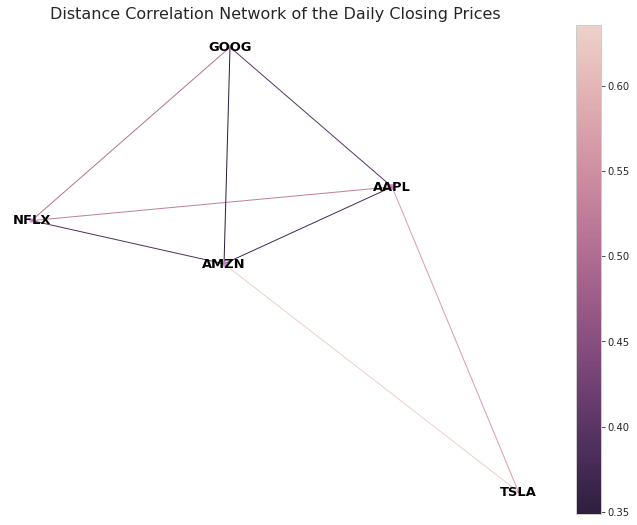

In [14]:
plt_corr_nx(df_h, title='Distance Correlation Network of the Daily Closing Prices')

In [15]:
def hist_plot(network, title, bins, xticks):
    deg_list = list(dict(network.degree).values())

    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(9,6))
        sns.distplot(
            deg_list,  
            kde=True,
            bins = bins,
            color='darksalmon',
            hist_kws={'alpha': 0.7}

        );
        
        plt.grid(False)
        plt.xticks(xticks, size=11)
        plt.yticks(size=11)
        sns.despine(left=True, right=True, bottom=True, top=True)
        plt.ylabel("Probability", size=15)
        plt.xlabel("Number of Connections", size=15)
        plt.title(title, size=20);
        plt.axvline(sum(deg_list)/len(deg_list), 
                    color='darkorchid', 
                    linewidth=3, 
                    linestyle='--', 
                    label='Mean = {:2.0f}'.format(sum(deg_list)/len(deg_list))
        )
        plt.legend(loc=0, fontsize=12)

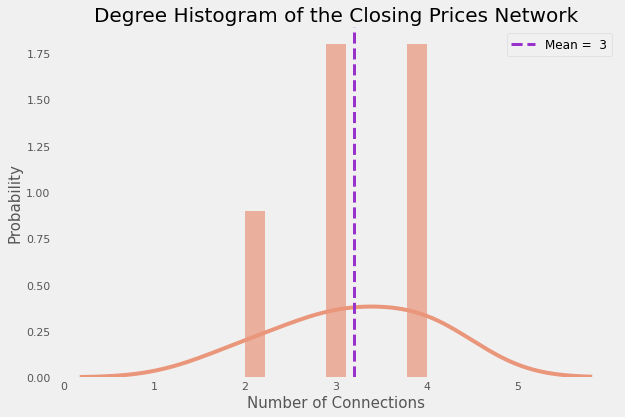

In [16]:
hist_plot(df_h, 'Degree Histogram of the Closing Prices Network',  bins=9, xticks=range(0, 6, 1))

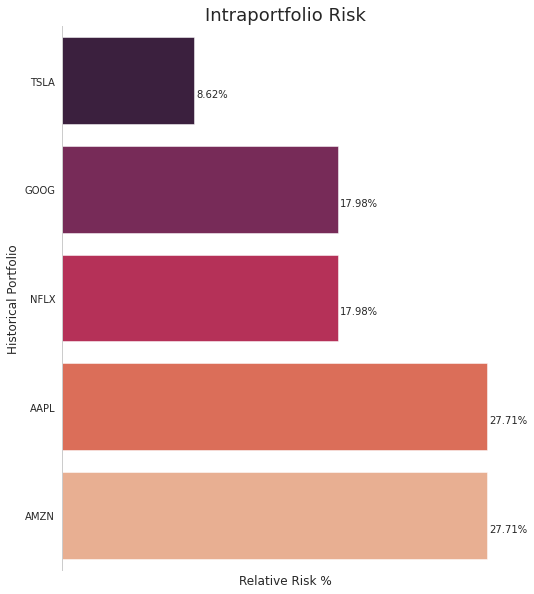

In [17]:
risk_alloc = nx.communicability_betweenness_centrality(df_h)
risk_alloc = pd.Series(risk_alloc)
risk_alloc = risk_alloc / risk_alloc.sum()
risk_alloc.reset_index()

risk_alloc = (
    pd.DataFrame({"Stocks": risk_alloc.index, "Risk Allocation": risk_alloc.values})
        .sort_values(by="Risk Allocation", ascending=True)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8,10))
    sns.barplot(x='Risk Allocation', y='Stocks', data=risk_alloc, palette="rocket")
    sns.despine(right=True, top=True, bottom=True)
    plt.xticks([])
    plt.xlabel("Relative Risk %", size=12)
    plt.ylabel("Historical Portfolio", size=12)
    plt.title("Intraportfolio Risk", size=18)
    
    for i, label in enumerate(list(risk_alloc.index)):
        height = risk_alloc.loc[label, 'Risk Allocation']
        label = (risk_alloc.loc[label, 'Risk Allocation']*100 ).round(2).astype(str) + '%'
        plt.annotate(str(label), (height + 0.001, i + 0.15))

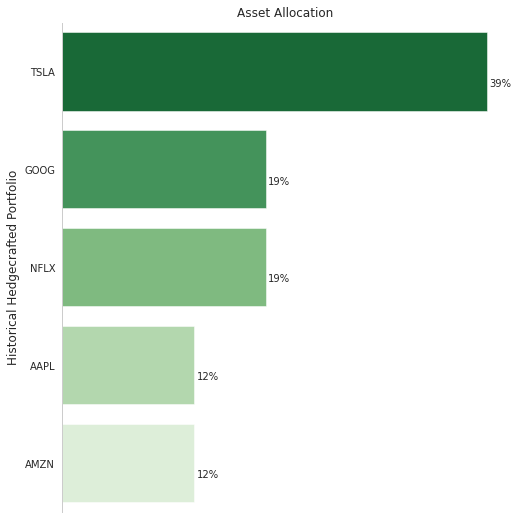

In [18]:
investment_A = nx.communicability_betweenness_centrality(df_h)
investment_A = 1 / pd.Series(investment_A)
investment_A = investment_A / investment_A.sum()
investment_A.reset_index()

investment_A = (
    pd.DataFrame({"Stocks": investment_A.index, "Asset Allocation": investment_A.values})
        .sort_values(by="Asset Allocation", ascending=False)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8,9))
    sns.barplot(x='Asset Allocation', y='Stocks', data=investment_A, palette="Greens_r")
    sns.despine(right=True, top=True, bottom=True)
    plt.xticks([])
    plt.xlabel('')
    plt.title("Asset Allocation", size=12)
    plt.ylabel("Historical Hedgecrafted Portfolio", size=12)
    
    capital = 100
    for i, label in enumerate(list(investment_A.index)):
        height = investment_A.loc[label, 'Asset Allocation']
        label = (investment_A.loc[label, 'Asset Allocation'] * capital).round(2)
        plt.annotate('{:,.0f}%'.format(label), (height + 0.002, i + 0.15))

In [19]:
investment_A = investment_A.set_index("Stocks").loc[stocks].reset_index()
weights = dict(zip(investment_A["Stocks"], investment_A["Asset Allocation"]))

In [20]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

In [21]:
weights = np.array([v for k, v in weights.items()])

In [22]:
risk_free_rate = 0.0178
p_var, p_ret = portfolio_annualized_performance(weights, returns.mean(), returns.cov())
sharpe_ratio = (p_ret - risk_free_rate)/p_var

In [23]:
sharpe_ratio

1.1470908016072379

In [24]:
-1*neg_prob_sharpe_ratio(weights, returns.mean(), np.log(data/data.shift(1)).dropna(), returns.cov(), risk_free_rate, 1.0)

0.7862856962005618